In [1]:
library(ggplot2)
library(gridExtra)
library(grid)
library(matrixStats)
library(fda)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'fda' was built under R version 3.6.3"Loading required package: Matrix

Attaching package: 'fda'

The following object is masked from 'package:graphics':

    matplot



# Load data

Set up the folders that contains data.

In [2]:
task = 'Rest'
adjust = 'gender_motion'

Load questionnaires, connectome  and variance explained data.

In [3]:
c = read.table(paste('Data/Connectome/', task, '/Adjust/c_adj_', adjust, '.csv', sep = ''), sep = ',', header = TRUE, row.names = 1)

In [4]:
q = read.table(paste('Data/Questionnaire/Adjust/q_adj_gender.csv', sep = ''), sep = ',', header = TRUE, row.names = 1)

Pick only negative questionnaires.

In [5]:
colnames(q)

[1] "AngAffect_Unadj"  "AngHostil_Unadj"  "AngAggr_Unadj"    "FearAffect_Unadj"
[5] "FearSomat_Unadj"  "Sadness_Unadj"

Load group labels.

In [6]:
grouping = read.table('Data/Connectome/region_to_region.csv', sep = ',', header = TRUE)

In [7]:
c = c[, as.character(grouping$Pair)]
groups = grouping$Region

# Load train and test subjects

In [8]:
subject_train = read.table(paste('Data/Questionnaire/subject_train.csv', sep = ''), sep = ',', header = TRUE)
subject_test = read.table(paste('Data/Questionnaire/subject_test.csv', sep = ''), sep = ',', header = TRUE)

In [9]:
c_train = as.matrix(c[as.character(subject_train$Subject),])
c_test = as.matrix(c[as.character(subject_test$Subject),])

In [10]:
q_train = as.matrix(q[as.character(subject_train$Subject),])
q_test = as.matrix(q[as.character(subject_test$Subject),])

# Load K-fold cross-validation split

In [11]:
split_train = subject_train$Split
K = max(split_train)

# Cross-Validated Group RCCA
Splits the data in train (90%) and test (10%) at random and returns the canonical correlations for training and test data.
Calculate 1SD confidence intervals for train and test canonical correlations.

In [12]:
GRCCA_CV = function(X, Y, lambda1s, mu1s, groups, split){
    ncomp = ncol(Y)
    n = nrow(X)
    K = max(split)
    colnames(X) = groups
    cor_cv = c()
    group_names = unique(sort(groups))
    ngs = table(groups)
    agg = aggregate(t(X), by = list(groups), FUN = mean)
    Xmean = t(agg[, -1])
    colnames(Xmean) = agg[, 1]  
    for(mu1 in mu1s){
        for(lambda1 in lambda1s){
            nu = mu1/lambda1
            #create extended matrix
            Xextended = cbind(scale(Xmean[,group_names], center = FALSE, scale = sqrt(nu/ngs[group_names])), X - Xmean[,groups])
            #compute R and V for extended matrix
            SVD = svd(Xextended)
            R = SVD$u %*% diag(SVD$d)
            V = SVD$v
            rownames(V) = colnames(Xextended)
            cor_train = matrix(0, ncomp, K)
            cor_test = matrix(0, ncomp, K)
            colnames(cor_train) = paste('split', 1:K, sep = '')
            colnames(cor_test) = paste('split', 1:K, sep = '')
            #repeat split nreps times and save train and test correlations
            for(k in 1:K){
                #split the data into train and test
                ind_test = (split == k)
                ind_train = (split != k)
                #run RCCA
                Crr = var(R[ind_train, ], na.rm = TRUE, use = "pairwise") + diag(lambda1, ncol(R))
                Cyy = var(Y[ind_train, ], na.rm = TRUE, use = "pairwise")
                Cry = cov(R[ind_train, ], Y[ind_train, ], use = "pairwise")
                RCCA = geigen(Cry, Crr, Cyy)
                names(RCCA) = c("cor", "xcoef", "ycoef")
                #transform alpha to Xextended basis
                RCCA$xcoef = V %*% RCCA$xcoef
                #transform alpha to X basis
                alphaXmean = RCCA$xcoef[1:ncol(Xmean),]
                alphaXmean = t(scale(t(alphaXmean), center = FALSE, scale = sqrt(ngs[rownames(alphaXmean)] * nu)))
                alphaX = RCCA$xcoef[-(1:ncol(Xmean)),]
                alpha = alphaX + alphaXmean[groups,]
                beta = RCCA$ycoef
                #compute train and test correlation
                cor_train[,k] = RCCA$cor
                cor_test[,k] = diag(cor(X[ind_test, ]%*%alpha, Y[ind_test, ]%*%beta))
            }
            cor_cv = rbind(cor_cv, data.frame(cor_train, 'comp' = 1:ncomp, 'set' = 'train', 'lambda1' = lambda1, 'mu1' = mu1), 
                             data.frame(cor_test, 'comp' = 1:ncomp, 'set' = 'test', 'lambda1' = lambda1, 'mu1' = mu1))
        }
    }
    return(cor_cv)
}

# Run grid search for GRCCA

Vary $\lambda_1$ and $\nu$ and compute GRCCA.

In [13]:
mu1s = 10^seq(-4,4)
lambda1s = 10^seq(-4,4)

cor_cv = GRCCA_CV(c_train, q_train, lambda1s, mu1s, groups, split_train)

In [14]:
write.csv(cor_cv, file = paste('Data/Connectome/', task, '/GRCCA/corelation_adj_', adjust, '_train_cv.csv', sep = ''), row.names = FALSE)

Plot GRCCA results for different values of $\lambda_1$ and $\nu$.

In [15]:
cor_plots = list()
ncomp = min(ncol(c), ncol(q))
i = 1
df = c()
for(m1 in mu1s){
    for(lam1 in lambda1s){
        cor_train = subset(cor_cv, lambda1 == lam1 & set == 'train' & mu1 == m1, select = -c(lambda1, mu1, set, comp))
        df_train = data.frame('component' = 1:ncomp, 'mean' = apply(cor_train, 1, mean), 'se' = apply(cor_train, 1, sd)/sqrt(K), 'set' = 'train', 'lambda1' = lam1, 'mu1' = m1) 
        cor_test = subset(cor_cv, lambda1 == lam1 & set == 'test' & mu1 == m1, select = -c(lambda1, mu1, set, comp))
        df_test = data.frame('component' = 1:ncomp, 'mean' = apply(cor_test, 1, mean), 'se' = apply(cor_test, 1, sd)/sqrt(K), 'set' = 'test', 'lambda1' = lam1, 'mu1' = m1) 
        df = rbind(df, df_train, df_test)
    }
}

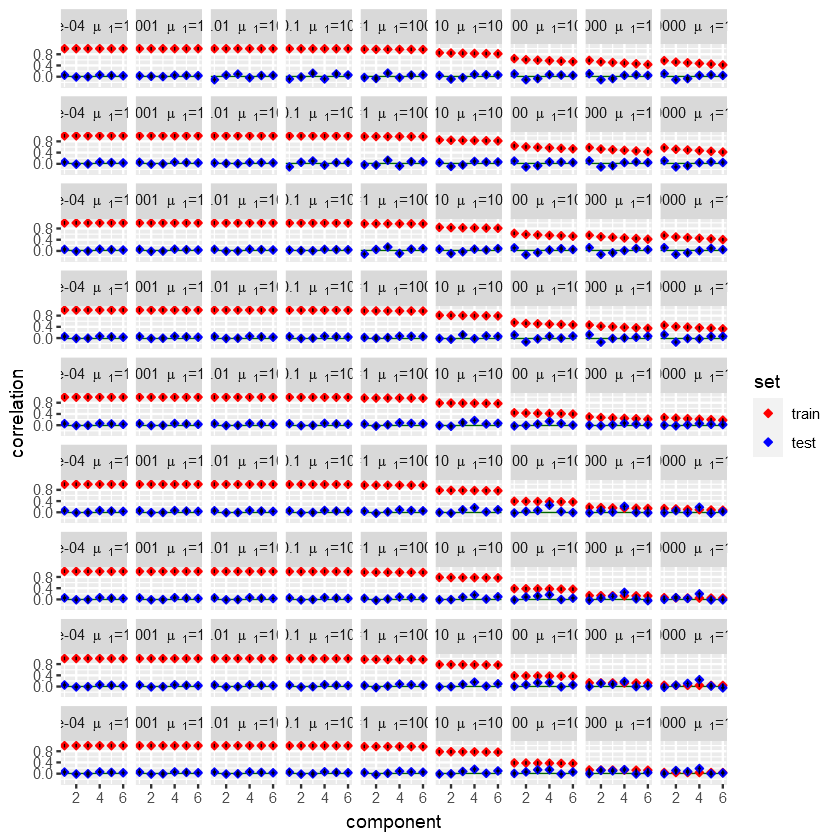

In [16]:
library(gridExtra) 
ggplot(df, aes(x = component, y = mean, fill = set, color = set, group = set)) +
geom_hline(yintercept = 0, size = 0.3, color = 'darkgreen')+
geom_point(size = 1.5, shape = 23) +
geom_errorbar(aes(ymin = mean - se, ymax = mean + se, group = set), width = 0.1, color = 'black', size = 0.7)+
facet_wrap(mu1~lambda1, ncol = length(lambda1s), labeller = label_bquote(paste(lambda[1], '=', .(lambda1), '  ', mu[1], '=', .(m1))))+
scale_fill_manual(values = c('red', 'blue'))+
scale_color_manual(values = c('red', 'blue'))+
ylim(-0.3, 1.1)+
ylab('correlation')
ggsave(file = paste('Data/Connectome/', task, '/GRCCA/grid_search_adj_', adjust,'.png', sep = ''), device = 'png', width = 15, height = 15)

Search for the best $\lambda_1$ and $\nu$ with the highest value of the first test canonical correlation.

In [17]:
df_first = subset(df, component == 1 & set == 'test')
df_opt = subset(df_first, mean == max(df_first$mean))
lambda1_opt = df_opt$lambda1
mu1_opt = df_opt$mu1
cor_opt = df_opt$mean

In [18]:
lambda1s_opt = lambda1s[aggregate(df_first$mean, by = list(df_first$mu1), FUN = which.max)[,2]]
cors_opt = aggregate(df_first$mean, by = list(df_first$mu1), FUN = max)[,2]
df_text = data.frame('label' = paste('max correlation = ', round(cors_opt, 3), '\n  lambda1 = ', lambda1s_opt),
'mu1' = unique(df_first$mu1))

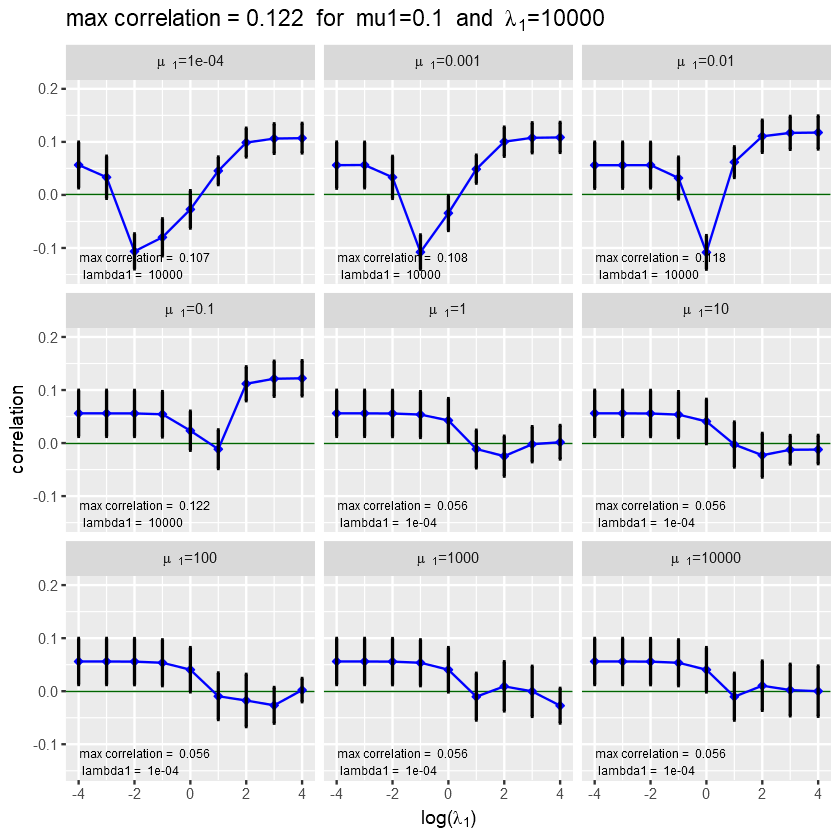

In [19]:
ggplot(df_first, aes(x = log(lambda1, 10), y = mean)) +
geom_hline(yintercept = 0, size = 0.3, color = 'darkgreen')+
geom_point(size = 1.5, shape = 23, color = 'blue', fill = 'blue') +
geom_line(color = 'blue')+
geom_errorbar(aes(ymin = mean - se, ymax = mean + se, group = set), width=0.1, color = 'black', size = 0.7)+
geom_text(df_text, mapping = aes(x = -Inf, y = -Inf, label = label), hjust = -0.1, vjust   = -0.2, size = 2.5)+
facet_wrap(~mu1, labeller = label_bquote(paste(mu[1], '=', .(mu1))))+
ylab('correlation')+
ylim(-0.15, 0.2)+
xlab(bquote(paste('log(', lambda[1], ')', sep = '')))+
ggtitle(bquote(paste('max correlation = ', .(round(cor_opt,3)), '  for  ', mu1, '=' , .(mu1_opt), '  and  ', lambda[1], '=', .(lambda1_opt))))
ggsave(file = paste('Data/Connectome/', task, '/GRCCA/best_lambda_adj_', adjust, '.png', sep = ''), device = 'png', width = 8, height = 8)

# Calculate RCCA for the best lambda.

In [20]:
GRCCA = function(X, Y, lambda1, mu1, groups){
    nu = mu1/lambda1
    colnames(X) = groups
    group_names = unique(sort(groups))
    ngs = table(groups)
    agg = aggregate(t(X), by = list(groups), FUN = mean)
    Xmean = t(agg[, -1])
    colnames(Xmean) = agg[, 1]
    Xextended = cbind(scale(Xmean[,group_names], center = FALSE, scale =  sqrt(nu/ngs[group_names])), X - Xmean[,groups])
    SVD = svd(Xextended)
    R = SVD$u %*% diag(SVD$d)
    V = SVD$v
    rownames(V) = colnames(Xextended)
    Cxx = var(R, na.rm = TRUE, use = "pairwise") + diag(lambda1, ncol(R))
    Cyy = var(Y, na.rm = TRUE, use = "pairwise")
    Cxy = cov(R, Y, use = "pairwise")
    res = geigen(Cxy, Cxx, Cyy)
    names(res) = c("cor", "xcoef", "ycoef")
    res$xcoef = V %*% res$xcoef
    alpha0 = res$xcoef[1:ncol(Xmean),]
    alpha0 = t(scale(t(alpha0), center = FALSE, scale = sqrt(ngs[rownames(alpha0)] * nu) ))
    alpha = res$xcoef[-(1:ncol(Xmean)),]
    res$xcoef = alpha + alpha0[groups,]    
    return(list(cor = res$cor, xcoef = res$xcoef, ycoef = res$ycoef))
}

In [21]:
best = GRCCA(as.matrix(c_train), as.matrix(q_train), lambda1_opt, mu1_opt, groups)

Save the loadings. 

In [22]:
alpha = best$xcoef
colnames(alpha) = paste('GRCCA', 1:ncol(alpha), sep = '')
beta = best$ycoef
colnames(beta) = paste('GRCCA', 1:ncol(beta), sep = '')
write.csv(data.frame('c_pair' = rownames(alpha), alpha), file = paste('Data/Connectome/', task, '/GRCCA/alpha_adj_', adjust,'.csv', sep = ''), row.names = FALSE)
write.csv(data.frame('q' = rownames(beta), beta), file = paste('Data/Connectome/', task, '/GRCCA/beta_adj_', adjust,'.csv', sep = ''), row.names = FALSE)

Save scores train.

In [23]:
brain_scores = as.matrix(c_train)%*%as.matrix(alpha)
write.csv(data.frame('Subject' = rownames(brain_scores), brain_scores), file = paste('Data/Connectome/', task, '/GRCCA/brain_scores_adj_', adjust,'_train.csv', sep = ''), row.names = FALSE)
questionnaire_scores = as.matrix(q_train)%*%as.matrix(beta)
write.csv(data.frame('Subject' = rownames(questionnaire_scores), questionnaire_scores), file = paste('Data/Connectome/', task, '/GRCCA/questionnaire_scores_adj_', adjust,'_train.csv', sep = ''), row.names = FALSE)
cors = diag(cor(brain_scores, questionnaire_scores))
write.csv(data.frame(t(cors)), file = paste('Data/Connectome/', task, '/GRCCA/correlation_adj_', adjust,'_train.csv', sep = ''), row.names = FALSE)
cors

GRCCA1    GRCCA2    GRCCA3    GRCCA4    GRCCA5    GRCCA6 
0.5292184 0.4566896 0.4358769 0.4310880 0.4062287 0.3900989

Save scores test.

In [24]:
brain_scores = as.matrix(c_test)%*%as.matrix(alpha)
write.csv(data.frame('Subject' = rownames(brain_scores), brain_scores), file = paste('Data/Connectome/', task, '/GRCCA/brain_scores_adj_', adjust,'_test.csv', sep = ''), row.names = FALSE)
questionnaire_scores = as.matrix(q_test)%*%as.matrix(beta)
write.csv(data.frame('Subject' = rownames(questionnaire_scores), questionnaire_scores), file = paste('Data/Connectome/', task, '/GRCCA/questionnaire_scores_adj_', adjust,'_test.csv', sep = ''), row.names = FALSE)
cors = diag(cor(brain_scores, questionnaire_scores))
write.csv(data.frame(t(cors)), file = paste('Data/Connectome/', task, '/GRCCA/correlation_adj_', adjust,'_test.csv', sep = ''), row.names = FALSE)
cors

GRCCA1        GRCCA2        GRCCA3        GRCCA4        GRCCA5 
-0.0010344624  0.1566255890  0.0555859145 -0.0428198691  0.0050971703 
       GRCCA6 
-0.0009093231

# Check mean and sd of coefficients

In [25]:
avg = aggregate(alpha, by = list(groups), FUN = mean)
rownames(avg) = avg[,1]
avg = avg[,-1]
quantile(avg[,1])

0%           25%           50%           75%          100% 
-0.0767414926 -0.0065857837  0.0004600482  0.0078383977  0.1084026710

In [26]:
sds = aggregate(alpha, by = list(groups), FUN = sd)
rownames(sds) = sds[,1]
sds = sds[,-1]
quantile(sds[,1], na.rm = TRUE)

0%          25%          50%          75%         100% 
6.965205e-07 2.254214e-06 2.594371e-06 2.934764e-06 6.825941e-06